<a href="https://colab.research.google.com/github/maverick98/CDS/blob/main/Code_for_Actor_Critic_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Group ID:
### Group Members Name with Student ID:
Student 1 Girija Shankar Sahoo 2023AA05235

Student 2 Sourajeet Sahoo 2023aa05029

Student 3 S Sridhar 2023ab05096

Student 4 Manoranjan Sahu 2023aa05738



# Problem Statement

The objective of the problem is to implement an Actor-Critic reinforcement learning algorithm to optimize energy consumption in a building. The agent should learn to adjust the temperature settings dynamically to minimize energy usage while maintaining comfortable indoor conditions.

#### Dataset Details
Dataset: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

This dataset contains energy consumption data for a residential building, along with various environmental and operational factors.

Data Dictionary:
* Appliances:       Energy use in Wh
* lights:           Energy use of light fixtures in the house in Wh
* T1 - T9:          Temperatures in various rooms and outside
* RH_1 to RH_9:     Humidity measurements in various rooms and outside
* Visibility:       Visibility in km
* Tdewpoint:       Dew point temperature
* Pressure_mm_hgg:  Pressure in mm Hg
* Windspeed:        Wind speed in m/s

#### Environment Details
**State Space:**
The state space consists of various features from the dataset that impact energy consumption and comfort levels.

* Current Temperature (T1 to T9): Temperatures in various rooms and outside.
* Current Humidity (RH_1 to RH_9): Humidity measurements in different locations.
* Visibility (Visibility): Visibility in meters.
* Dew Point (Tdewpoint): Dew point temperature.
* Pressure (Press_mm_hg): Atmospheric pressure in mm Hg.
* Windspeed (Windspeed): Wind speed in m/s.

Total State Vector Dimension: Number of features = 9 (temperature) + 9 (humidity) + 1 (visibility) + 1 (dew point) + 1 (pressure) + 1 (windspeed) = 22 features

**Target Variable:** Appliances (energy consumption in Wh).

**Action Space:**
The action space consists of discrete temperature adjustments:
* Action 0: Decrease temperature by 1°C
* Action 1: Maintain current temperature
* Action 2: Increase temperature by 1°C


- If the action is to decrease the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) down by 1°C.
- If the action is to increase the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) up by 1°C.
- Other features remain unchanged.

**Policy (Actor):** A neural network that outputs a probability distribution over possible temperature adjustments.

**Value function (Critic):** A neural network that estimates the expected cumulative reward (energy savings) from a given state.

**Reward function:**
The reward function should reflect the overall comfort and energy efficiency based on all temperature readings. i.e., balance between minimising temperature deviations and minimizing energy consumption.

* Calculate the penalty based on the deviation of each temperature from the target temperature and then aggregate these penalties.
* Measure the change in energy consumption before and after applying the RL action.
* Combine the comfort penalty and energy savings to get the final reward.

*Example:*

Target temperature=22°C

Initial Temperatures: T1=23, T2=22, T3=21, T4=23, T5=22, T6=21, T7=24, T8=22, T9=23

Action Taken: Decrease temperature by 1°C for each room

Resulting Temperatures: T1 = 22, T2 = 21, T3 = 20, T4 = 22, T5 = 21, T6 = 20, T7 = 23, T8 = 21, T9 = 22

Energy Consumption: 50 Wh (before RL adjustment) and 48 Wh (after RL adjustment)
* Energy Before (50 Wh): Use the energy consumption from the dataset at the current time step.
* Energy After (48 Wh): Use the energy consumption from the dataset at the next time step (if available).

Consider only temperature features for deviation calculation.

Deviation = abs (Ti− Ttarget )

Deviations=[ abs(22−22), abs(21−22), abs(20−22), abs(22−22),  abs(21−22), abs(20−22), abs(23−22), abs(21−22), abs(22−22) ]

Deviations = [0, 1, 2, 0, 1, 2, 1, 1, 0], Sum of deviations = 8

Energy Savings = Energy Before−Energy After = 50 – 48 = 2Wh

Reward= −Sum of Deviations + Energy Savings = -8+6 = -2

#### Expected Outcomes
1. Pre-process the dataset to handle any missing values and create training and testing sets.
2. Implement the Actor-Critic algorithm using TensorFlow.
3. Train the model over 500 episodes to minimize energy consumption while maintaining an indoor temperature of 22°C.
4. Plot the total reward obtained in each episode to evaluate the learning progress.
5. Evaluate the performance of the model on test set to measure its performance
6. Provide graphs showing the convergence of the Actor and Critic losses.
7. Plot the learned policy by showing the action probabilities across different state values (e.g., temperature settings).
8. Provide an analysis on a comparison of the energy consumption before and after applying the reinforcement learning algorithm.


In [ ]:
!wget https://archive.ics.uci.edu/static/public/374/appliances+energy+prediction.zip
!unzip /content/appliances+energy+prediction.zip

--2024-09-15 23:56:55--  https://archive.ics.uci.edu/static/public/374/appliances+energy+prediction.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘appliances+energy+prediction.zip’

appliances+energy+p     [  <=>               ]  11.42M  50.7MB/s    in 0.2s    

2024-09-15 23:56:56 (50.7 MB/s) - ‘appliances+energy+prediction.zip’ saved [11979507]

Archive:  /content/appliances+energy+prediction.zip
 extracting: energydata_complete.csv  


# Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#### Code Execution

#1. Pre-process the dataset

In [ ]:
 # Define features and target
features = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'Visibility', 'Tdewpoint', 'Press_mm_hg', 'Windspeed']
target = 'Appliances'


In [ ]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    # Convert 'date' column to datetime objects
    data['date'] = pd.to_datetime(data['date'])

    # Handle missing values for numeric features only
    numeric_data = data.select_dtypes(include=[np.number])
    numeric_data.fillna(numeric_data.mean(), inplace=True)
    data[numeric_data.columns] = numeric_data

    # Handle missing values (Example: Fill with mean)
    data.fillna(data.mean(), inplace=True)

    # Initialize the scaler
    scaler = StandardScaler()

    # Apply StandardScaler only to the selected features
    data[features] = scaler.fit_transform(data[features])



    X = data[features]
    y = data[target]

    # Normalize features
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    return data,X_train, X_test, y_train, y_test

#### Defining Actor Critic Model using tensorflow (1 M)

In [ ]:
def build_actor_model(state_dim, action_dim):
    model = tf.keras.Sequential([

        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(action_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

def build_critic_model(state_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(state_dim,)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

### Reward Function (0.5 M)

In [ ]:
def calculate_reward(initial_energy, final_energy, temp_deviations):
    #print('----****------')
    #print(f'initial_energy {initial_energy} ')
    #print(f'final_energy {final_energy} ')
    deviation_penalty = -np.sum(temp_deviations)
    energy_savings = initial_energy - final_energy
    #print(f'energy_savings {energy_savings} ')
    #print(f'temp_deviations {temp_deviations} ')
    reward = deviation_penalty + energy_savings
    #print(f'reward {reward} ')
    #print('----------')
    return reward

#### Environment Simulation (0.5 M)


In [ ]:
def find_matching_index(df, ndarray, features):
    state = pd.Series(ndarray, index=features)
    matching_columns = state.index
    subset_df = df[matching_columns]
    state_df = pd.DataFrame([state], columns=matching_columns)
    current_index = subset_df[subset_df.isin(state_df.to_dict(orient='list')).all(axis=1)].index
    #return current_index.tolist()[0] if not current_index.empty else None
    return current_index
def simulate_environment(action, state, data):
    #print(f'state {state}')
    #print(f'action {action}')
    next_state = state.copy()

    # Adjust temperatures based on action
    if action == 0:  # Decrease temperature
        next_state[:9] -= 1
    elif action == 2:  # Increase temperature
        next_state[:9] += 1
    #print('MS debug 1')
    # Get energy before and after the action
    current_index=find_matching_index(data, state, features)

    next_index = current_index + 1
    if next_index >= len(data):
        next_index = len(data) - 1
    energy_before = data.iloc[current_index]['Appliances'].item()
    energy_after = data.iloc[next_index]['Appliances'].item()

    # Calculate the reward
    temp_deviations = np.abs(next_state[:9] - 22)  # assuming 22°C as target
    reward = calculate_reward(energy_before, energy_after, temp_deviations)

    return next_state, reward

#### Implementation of Training Function (2 M)

In [ ]:
def train_actor_critic(X_train, y_train,data_df, episodes=500):
    state_dim = X_train.shape[1]
    action_dim = 3  # Decrease, Maintain, Increase

    actor_model = build_actor_model(state_dim, action_dim)
    critic_model = build_critic_model(state_dim)

    rewards = []

    for episode in range(episodes):
        print(f'episode {episode}')
        state = X_train.iloc[np.random.randint(0, len(X_train))]

        done = False

        while not done:
            # Get action probabilities and choose action
            action_probs = actor_model.predict(np.array(state).reshape(1, -1))
            action = np.random.choice(action_dim, p=action_probs[0])

            # Simulate environment
            next_state, reward = simulate_environment(action, state, data_df)
            reward = tf.convert_to_tensor(reward, dtype=tf.float32)

            # Update Critic
            target = reward + 0.99 * critic_model.predict(np.array(next_state).reshape(1, -1))
            critic_model.train_on_batch(np.array(state).reshape(1, -1), target)

            # Calculate advantages
            advantages = reward - critic_model.predict(np.array(state).reshape(1, -1))

            # Update Actor
            with tf.GradientTape() as tape:
                action_probs = actor_model(np.array(state).reshape(1, -1))
                action_log_probs = tf.math.log(action_probs[0][action])
                loss = -action_log_probs * advantages
            grads = tape.gradient(loss, actor_model.trainable_variables)
            actor_model.optimizer.apply_gradients(zip(grads, actor_model.trainable_variables))

            state = next_state
            done = True  # Simplified for demonstration

        rewards.append(reward.numpy())

    return actor_model, critic_model, rewards

#### Evaluate the performance of the model on test set (0.5 M)

In [ ]:
def evaluate_model(actor_model, X_test, y_test,data_df):
    total_rewards = []
    X_test = X_test.reset_index(drop=True)
    for i in range(len(X_test)):
        print(f'i = {i}')
        state = X_test.iloc[i]
        action_probs = actor_model.predict(np.array(state).reshape(1, -1))
        action = np.argmax(action_probs)
        #print(f'max action {action}')
        next_state, reward = simulate_environment(action, state, data_df)
        #print(f'next_state, reward {next_state}, {reward}')
        total_rewards.append(reward)
        print(f'reward {reward}')
    return np.mean(total_rewards)

::### Plot the convergence of Actor and Critic losses (1 M)

In [ ]:
def plot_results(rewards, actor_loss, critic_loss):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.title('Total Reward per Episode')

    plt.subplot(1, 3, 2)
    plt.plot(actor_loss)
    plt.title('Actor Loss')

    plt.subplot(1, 3, 3)
    plt.plot(critic_loss)
    plt.title('Critic Loss')

    plt.show()

### Plot the learned policy - by showing the action probabilities across different state values (1 M)

In [ ]:
def plot_learned_policy(actor_model, X_train):
    # Convert the DataFrame to a NumPy array
    X_train = X_train.values
    temp_ranges = np.linspace(min(X_train[:, 0]), max(X_train[:, 0]), num=10)
    action_probs = []

    for temp in temp_ranges:
        state = np.array([temp] + [0] * (X_train.shape[1] - 1))
        probs = actor_model.predict(np.array(state).reshape(1, -1))
        action_probs.append(probs[0])

    plt.figure(figsize=(8, 6))
    plt.plot(temp_ranges, np.array(action_probs)[:, 0], label='Decrease')
    plt.plot(temp_ranges, np.array(action_probs)[:, 1], label='Maintain')
    plt.plot(temp_ranges, np.array(action_probs)[:, 2], label='Increase')
    plt.xlabel('Temperature')
    plt.ylabel('Action Probability')
    plt.title('Learned Policy')
    plt.legend()
    plt.show()



episode 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
episode 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
episode 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
episode 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
episode 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
episode 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
episode 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
episode 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
episode

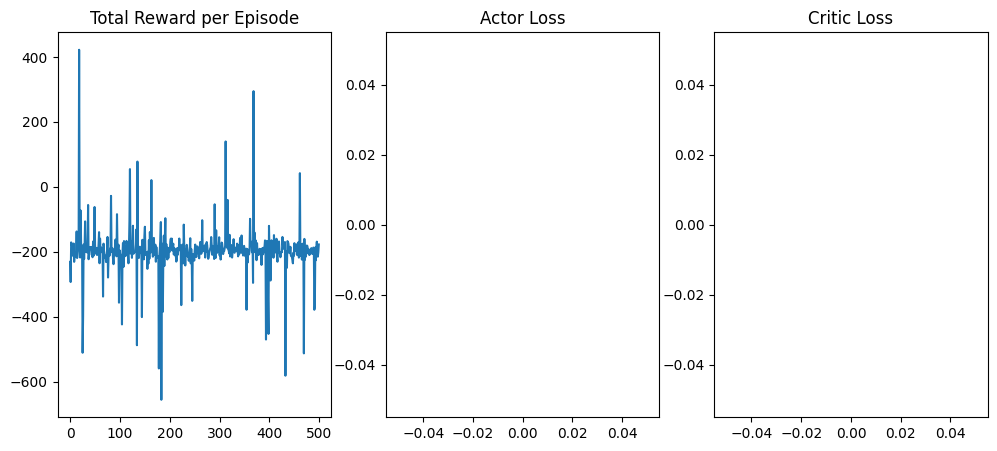

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


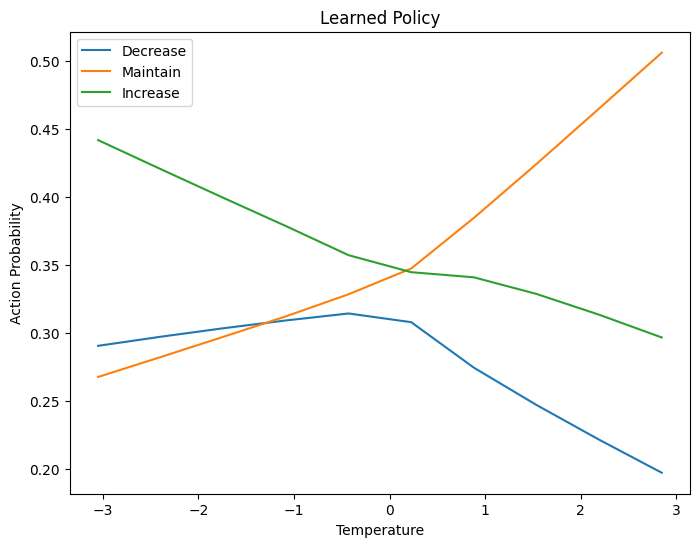

In [ ]:
file_path = '/content/energydata_complete.csv'
data_df,X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path)
actor_model, critic_model, rewards = train_actor_critic(X_train, y_train,data_df,episodes=500)
plot_results(rewards, actor_loss=[], critic_loss=[])  # Placeholder for actual loss values
plot_learned_policy(actor_model, X_train)



In [ ]:
evaluate_model(actor_model, X_test, y_test,data_df)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
reward -177.2591527823369
i = 2203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
reward -215.851661508714
i = 2204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
reward -214.23392580731016
i = 2205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
reward -202.18032820497018
i = 2206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
reward -202.69100895129594
i = 2207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
reward -208.95880853750472
i = 2208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
reward -229.52203584131917
i = 2209
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
reward -191.18127215678788
i = 2210
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
reward -186.39950601521653
i = 2211
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
reward -194.4204031852807
i = 2212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
reward -194.87843254951576
i = 2213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
reward -179.43422522968507
i = 2214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
reward -187.72174897459234


#### Conclusion (0.5 M)

In [ ]:
# Provide an analysis on a comparison of the energy consumption
# before and after applying the reinforcement learning algorithm.